<center> <b> <font size="3"> <font color="green">rfborg </font> :
    your detector technology will be assimilated— resistance is futile! </font> </b> </center> 

**Filename:** 202306091208_blast_silver_fixed_eth.ipynb

Changes:
1. Recompiled firmware in vivado2020.2 and otherwise made no changes 202306081533
2. Recompiled firmware with replaced FFT
3. 202306091138
    Cleaned up code to correct for erroneous spacing, register naming, etc...
4. 202306091243
    Modified offsets in firmware to match new design with (hopefully) fixed ethernet

In [4]:
import os
from pynq import Overlay
from pynq import MMIO
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as ipw
from ipywidgets import interact, interactive, fixed, interact_manual
from scipy import signal

In [5]:
# Load bitstream
firmware = Overlay("202306091243_silver_blast_fixedeth.bit",ignore_version=True)

In [6]:
# INITIALIZING LMK04208 rf data converter dac/adc reference clock
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

In [7]:
###########################
# Firmware Registers and Aliasing
###########################
dst_mac_reg = firmware.IP_MAC_gpio_hier.dst_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
src_mac_reg = firmware.IP_MAC_gpio_hier.src_mac # 48 bits, offset 0x00 bottom 32bits, 0x08 top 16 bits
ip_reg = firmware.IP_MAC_gpio_hier.ip # offset 0x00 src ip, offset 0x08 dst ip
eth_delay_reg = firmware.eth_delay # programmable delay for eth byte shift
data_in_mux = firmware.data_in_mux
bram_ADC_I = firmware.ADC_I.BRAM_SNAP_0 
bram_ADC_Q = firmware.ADC_Q.BRAM_SNAP_0
pfbIQ = firmware.PFB_SNAP_SYNC.BRAM_SNAPIII_0
ddc_snap = firmware.DDC_SNAP_SYNC.BRAM_SNAPIII_0
accum_snap = firmware.ACCUM_SNAP_SYNC.BRAM_SNAPIII_0
fft_shift_and_load_bins = firmware.gpio1.axi_gpio_0 # 0x00 fft shift, 0x08 load bins
accum_and_bin_idx = firmware.gpio2.axi_gpio_0 # 0x00 bins, 0x08 0b-23b accum len, 24b accum rst, 26b sync in
dds_shift=firmware.gpio3.axi_gpio_0 # DDS SHIFT offset = 0x00, 0x08 is open

In [8]:
# setting ips
src_ip_int32 = int("c0a80330",16)
dst_ip_int32 = int("c0a80328",16)
src_mac0_int32 = int("deadbeef",16)
src_mac1_int16 = int("feed",16)
dst_mac0_int32 = int("a2123651",16) # Readout computer UDP destination mac address 2,3,4,5
dst_mac1_int16 = int("681c",16) # readout computer UDP destination mac address bytes 0,1

# write values
ip_reg.write( 0x00, src_ip_int32) 
ip_reg.write( 0x08, dst_ip_int32)
dst_mac_reg.write( 0x00, dst_mac0_int32)
dst_mac_reg.write( 0x08, dst_mac1_int16)
src_mac_reg.write( 0x00, src_mac0_int32)
src_mac_reg.write( 0x08, src_mac1_int16)

In [9]:
###############################
# Ethernet Delay Lines  
###############################
eth_delay_reg.write(0x00, 37 + (4<<16))#44 + (4<<16)) # data output from eth buffer delay/ input to eth buffer delay <<16 delay
eth_delay_reg.write(0x08, 43) # start pulse out delay   3,10 -> for later :)  37,27?
###############################
# Data MUX
###############################
data_in_mux.write( 0x00, 1) # coffee when 0, data when 1
data_in_mux.write( 0x08, (509) + ((8189)<<16) ) # ethernet max write count and max read count

# Generating DDS/DAC Waveform

In [10]:
def phase_shift(ts, phase):
    y = ts*np.exp(1j*phase)
    return ts.real + 1j*y.imag 

def norm_wave(ts, max_amp=2**15-1):
    """
     Re-configure generated data values to fit LUT
    """
    Imax = max(abs(ts.real))
    Qmax = max(abs(ts.imag))
    norm = max(abs(ts))
    dacI = ((ts.real/norm)*max_amp).astype("int16")
    dacQ = ((ts.imag/norm)*max_amp).astype("int16")
    return dacI, dacQ

def surfsUpDude(freq_list, vna = False, verbose=False):
    """
    surfsUpDude Takes a list of specified frequencies and generates....stuff and things, then 
    uploads to the bram. Then we'll have totally ripped waves bruh, schralping the gnar.
    
    params
        freq_list: np.array
            list of tones to generate [Hz]
        verbose: bool
            enable / disable printing (and or) plotting of data
    """
    #####################################################
    # HARDCODED LUT PARAMS
    #####################################################
    addr_size=18   # address bit width
    channels= 2    # data points per memory address for DAC
    fs = 1024e6    # sampling rate of D/A, FPGA fabric = fs/2
    C=2            # decimation factor
    data_p = channels*2**(addr_size) # length of timestream or length of LUT+1
    
    #####################################################
    #  SET FREQ for LUT
    #####################################################
    if vna:
        N = 1000
        Nover2 = 500 # number of tones to make
        freqs_up = -1.0*C*np.linspace(251.0e6,1.0e6,Nover2)
        freqs_lw = 1.0*C*np.linspace(2.25e6,252.25e6,Nover2)
        freqs = np.append(freqs_up,freqs_lw)
    else:
        freqs = C*freq_list # equally spaced tones
    phases = np.random.uniform(-np.pi,np.pi,len(freqs))

    ######################################################
    # DAC Params
    ######################################################
    A = 2**15-1 # 16 bit D/A, expecting signed values.
    freq_res = fs/data_p # Hz
    fftbin_bw = 500e3 # Hz for effective bandwidth of 512MHz/1024 point fft on adc
    
    ######################################################
    # GENERATE LUT WAVEFORM FROM FREQ LIST
    ######################################################
    freqs = np.round(freqs/(freq_res))*freq_res
    delta = np.zeros(data_p,dtype="complex") # empty array of deltas
    fft_bin_nums=np.zeros(len(freqs),dtype=int) # array of all dac bin index
    
    for i in range(len(freqs)):
        bin_num = np.round((freqs[i]/freq_res)).astype('int')
        fft_bin_nums[i]=(np.round((freqs[i]/fftbin_bw/C)).astype('int'))*C
        delta[bin_num] = np.exp(1j*phases[i]) 
        print(delta[bin_num])
    ts = np.fft.ifft(delta)

    # GENERATE DDC WAVEFORM FROM BEAT FREQS
    f_fft_bin = fft_bin_nums*fftbin_bw
    f_beat = (freqs/C - f_fft_bin/C)
    

    ###########
    # new DDC
    ###########
    wave_ddc = np.zeros( int(data_p), dtype="complex") # empty array of deltas
    delta_ddc = np.zeros( shape=(len(freqs),2**9), dtype="complex") # empty array of deltas
    beat_ddc = np.zeros(shape=(len(freqs),2**9), dtype="complex")
    bin_num_ddc = np.round(f_beat*2/freq_res) # factor of 2 for half a bin width

    for i in range(len(freqs)): 
        delta_ddc[i,int(bin_num_ddc[i])] = np.exp(-1j*phases[i])
        beat_ddc[i] = np.conj(np.fft.ifft(delta_ddc[i]))
        
    for i in range(1024):
        if (i<len(freqs)):
            wave_ddc[i::1024] = beat_ddc[i]
        else:
            wave_ddc[i::1024] = 0
    
    dacI, dacQ = norm_wave(ts)
    ddcI, ddcQ = norm_wave(wave_ddc, max_amp=(2**13)-1)
    return dacI, dacQ, ddcI, ddcQ, freqs

# begin new 
def load_DAC(wave_real, wave_imag):
    base_addr_DAC_I = 0x0400000000 # Address assigned in vivado
    base_addr_DAC_Q = 0x0400100000 # Address assigned in vivado
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DAC_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DAC_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144] # half of data
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DAC waveform uploaded to AXI BRAM")
    return


def load_DDS(wave_real, wave_imag):
    
    base_addr_DDS_I = 0x0080000000 # Address assigned in vivado
    base_addr_DDS_Q = 0x0080100000 # Address assigned in vivado
    mem_size = 262144*4 # 32 bit address slots
    mmio_bramI = MMIO(base_addr_DDS_I,mem_size)
    mmio_bramQ = MMIO(base_addr_DDS_Q,mem_size)
    I0, I1 = wave_real[0::2], wave_real[1::2]
    Q0, Q1 = wave_imag[0::2], wave_imag[1::2]
    dataI = ((np.int32(I1) << 16) + I0).astype("int32")
    dataQ = ((np.int32(Q1) << 16) + Q0).astype("int32")
    mmio_bramI.array[0:262144] = dataI[0:262144] # half of data
    mmio_bramQ.array[0:262144] = dataQ[0:262144]
    print("DDC waveform uploaded to AXI BRAM")
    return


def load_bin_list(freqs):
    #bin_list=-1*(np.round(freqs* 512/512e6))
    bin_list = np.int64( np.round(freqs/1e6) )
    sync_in = 2**26
    accum_rst = 2**24  # (active low)
    accum_length = (2**19)-1

    ################################################
    # Load DDC bins
    ################################################
    offs=20
    
    # only write tones to bin list
    for addr in range(1024):
        if ((offs-1)<addr<((offs)+len(bin_list))):
            accum_and_bin_idx.write(0x00, int(bin_list[addr-offs])) #110 # write bin for address single address
            fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
            fft_shift_and_load_bins.write(0x08,0) # disable we
        else:
            accum_and_bin_idx.write(0x00,0)#0) #110 # write bin for address single address
            fft_shift_and_load_bins.write(0x08,(addr<<1)+1) # enable we
            fft_shift_and_load_bins.write(0x08,0) # disable we
    return

def load_waveform_into_mem(freqs, dac_r,dac_i,dds_r,dds_i):
    #######################################################
    # Load configured LUT values into FPGA memory
    #######################################################
    
    # Arming DDC Waveform
    ########################
    # initialization 
    
    sync_in = 2**26
    accum_rst = 2**24  # (active redge)
    accum_length = (2**19)-1 # (2**18)-1
    
    fft_shift=0
    if len(freqs)<400:
        fft_shift = 1*((2**9)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    else:
        fft_shift = 1*((2**5)-1) #(2**7)-1 # CHANGED FOR NEW GPIO
    
    
    dds_shift.write(0x00,193) # WRITING TO DDS SHIFT 
    accum_and_bin_idx.write(0x08,1*accum_length) #100
    
    # accum reset low then high
    fft_shift_and_load_bins.write(0x00,2**11) # reset DAC/DDS counter
    accum_and_bin_idx.write(0x08,1*accum_length+0*sync_in+1*accum_rst) # 101 

    load_DAC(dac_r,dac_i)
    load_DDS(dds_r,dds_i)
    sleep(.5)
    fft_shift_and_load_bins.write(0x00, fft_shift+2**10) # enable DAC/DDS counter
    ########################
    accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+0*accum_rst) # 110 -- STARTS DSP FIRMWARE
    sleep(0.5)
    accum_and_bin_idx.write(0x08,1*accum_length+1*sync_in+1*accum_rst) #111
    
    return 0

In [11]:
# ADC
def get_snap_data(snap):
    snap.write(0x04,0)       #
    snap.write(0x04,2**31)   # toggling sync clear
    snap.write(0x04,2**29)   # 
    d = np.zeros(2**11)    # bram data
    
    for i in range(2**11):
        snap.write(0x00,i<<(32-11)) # write address space to read
        for j in range(1):
            snap.write(0x04,j<<19)
            data = snap.read(0x08)
            d[i*1+j]= data
      #print(str(i*8+j))
    snap_data = np.array(d).astype("int32")
    snap_data_0 = ((snap_data >> 16).astype("int16"))#.astype('float') # decoding concatenated values
    snap_data_1 = ((snap_data & (2**(16)-1)).astype("int16"))#.astype('float') 
    d2 = np.zeros(2*2**11)# bram data
    d2[0::2]=snap_data_1
    d2[1::2]=snap_data_0
    return d2

# PFB
def get_pfb_data(snap): # make sure to toggle sync (gpio) first
    snap.write(0x04,0)       #
    snap.write(0x04,2**31)   # toggling sync clear
    snap.write(0x04,2**29)   # 

    d = np.zeros(4*2**11)# bram data 
    
    for i in range(2**11):
        snap.write(0x00,i<<(32-11)) # write address space to read
        for j in range(4):
            snap.write(0x04,j<<19)
            data = snap.read(0x08)
            d[i*4+j]= data

    snap_data = np.array(d).astype("uint32")
    snap_data=snap_data<<14
    return snap_data

def get_ddc_data(snap):
    snap.write(0x04,0)       #
    snap.write(0x04,2**31)   # toggling sync clear
    snap.write(0x04,2**29)       # 
    d = np.zeros(4*2**11)# bram data 
    
    for i in range(2**11):
        snap.write(0x00,i<<(32-11)) # write address space to read
        for j in range(4):
            snap.write(0x04,j<<19)
            data = snap.read(0x08)
            d[i*4+j]= data

    snap_data = np.array(d).astype("uint32")
    return snap_data<<13

# DDC
def get_accum_data(snap,slp=.3):
    snap.write(0x04,0)       #
    snap.write(0x04,(2**29) + (2**31))   # toggling sync clear
    snap.write(0x04,2**29)       # 
    sleep(slp)

    d = np.zeros(4*2**11)# bram data 
    
    for i in range(2**11):
        snap.write(0x00,i<<(32-11)) # write address space to read
        for j in range(4):
            snap.write(0x04,j<<19)
            data = snap.read(0x08)
            d[i*4+j]= data
    snap_data = np.array(d)#.astype("int32")
    return snap_data

<h3> Create and Write Waveform </h3>

In [12]:
frequencylist = np.array([100e6])

LUT_I, LUT_Q, DDS_I, DDS_Q, freqs = surfsUpDude(frequencylist, vna=True, verbose=False)
load_bin_list(freqs)
load_waveform_into_mem(freqs, LUT_I, LUT_Q, DDS_I, DDS_Q)

(0.8833838001596074-0.46865025511096314j)
(0.34460740591043515+0.9387468965550195j)
(0.9319020107560562+0.36271013543712766j)
(0.3053853078024979+0.9522288662807769j)
(0.9828744128130533+0.1842766633011238j)
(-0.7752286045728995-0.6316807822404881j)
(-0.9903225160856434-0.13878513657377248j)
(-0.650468611128328+0.7595331368260269j)
(-0.6666731864434038+0.7453501609830098j)
(-0.8617209911562594-0.5073824330824568j)
(-0.35274896371409536+0.9357179962994363j)
(0.9995405396027038+0.030310224194743662j)
(-0.8256007801959933-0.5642546869453255j)
(-0.11208922204717921-0.9936981464714816j)
(0.9999952082879326+0.003095706894090568j)
(-0.9474950478258559-0.31977044007456196j)
(-0.8957287914437656+0.44460086839624036j)
(-0.8984391560558453-0.4390980333201918j)
(0.25722110254309116+0.9663525776891768j)
(0.5494586733114625-0.8355208952041879j)
(-0.5427354505505956+0.8399037032396285j)
(0.3167363812364532-0.9485136081265446j)
(-0.9219134809122834+0.3873958359510293j)
(0.875832939784678+0.48261440259

0

# ADC DATA

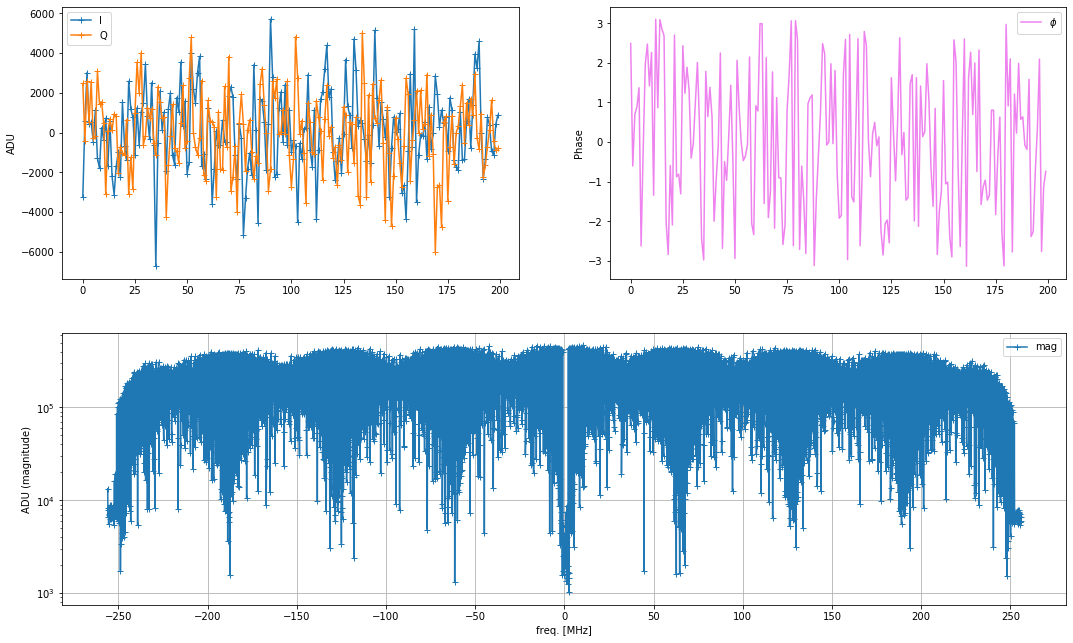

In [18]:
Q3=get_snap_data(bram_ADC_Q) # Q must run first, I is dependent on Q triggering!!!
I3=get_snap_data(bram_ADC_I)

plt.figure(figsize=(18,11))
c = slice(0,200)

# Plot I/Q data from ADC
plt.subplot(221)
plt.plot(I3[c],"-+",label="I")
plt.plot(Q3[c],"-+",label="Q")
plt.ylabel("ADU")
plt.legend()

# Plot I/Q phase from ADC
plt.subplot(222)
plt.plot(np.arctan2(Q3[c],I3[c]),color="violet",label=r'$\phi$')
plt.ylabel("Phase")
plt.legend()

# Plot FFT of ADC
plt.subplot(2,2,(3,4))
spec=np.fft.fft(I3+1j*Q3)
spec_freqs = np.fft.fftfreq(len(I3),1/512e6)
spec=abs(spec)
plt.semilogy(np.fft.fftshift(spec_freqs)*1e-6,np.fft.fftshift(spec),"-+",label="mag")
plt.ylabel("ADU (magnitude)"); plt.xlabel("freq. [MHz]")
plt.xticks(np.linspace(-250,250,11,dtype="int32"))
plt.grid() 
plt.legend()
plt.show()

## Polyphase Filterbank Snap

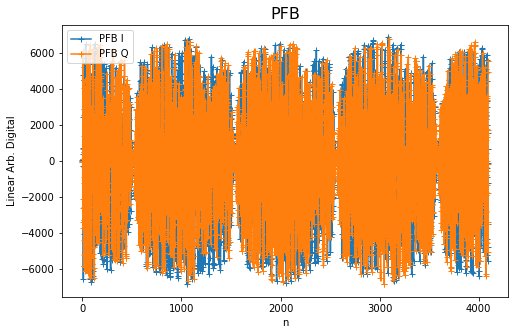

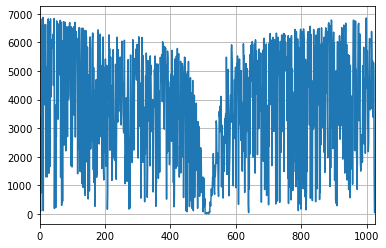

In [19]:
IQpfb_dat = get_pfb_data(pfbIQ).astype("int32")

Ipfb_f = IQpfb_dat[0::2].astype("float")/2**14
Qpfb_f = IQpfb_dat[1::2].astype("float")/2**14

SPECpfb = Ipfb_f + 1j*Qpfb_f
mag = abs(SPECpfb)

plt.figure(figsize=(8,5))
plt.xlabel("n"); plt.ylabel("Linear Arb. Digital")
plt.plot(Ipfb_f,"-+",label='PFB I')
plt.plot(Qpfb_f,"-+",label='PFB Q')
plt.title("PFB",fontsize=16)
plt.legend()
plt.show()

plt.figure()
plt.plot(mag[:])
plt.xlim(0,1024)
plt.grid()

# Digital Down Conversion

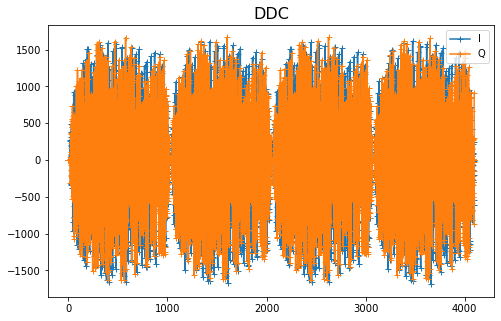

In [20]:
ddc_IQ_dat = get_ddc_data(ddc_snap).astype("int32")

Iddc_f = ddc_IQ_dat[0::2].astype("float")/2**13
Qddc_f = ddc_IQ_dat[1::2].astype("float")/2**13
IQddc=abs(Iddc_f+1j*Qddc_f)

plt.figure(figsize=(8,5))
plt.title("DDC",fontsize=16)
plt.plot(Iddc_f,"-+",label='I')
plt.plot(Qddc_f,"-+",label='Q')
plt.legend()
plt.show()

## Vector Accumulate and Downsample

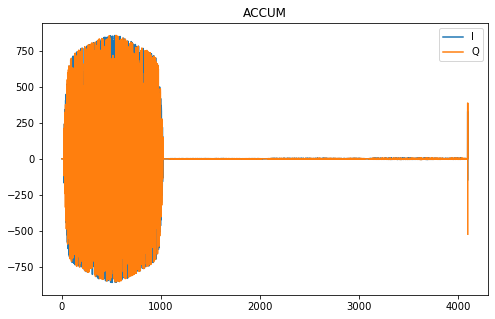

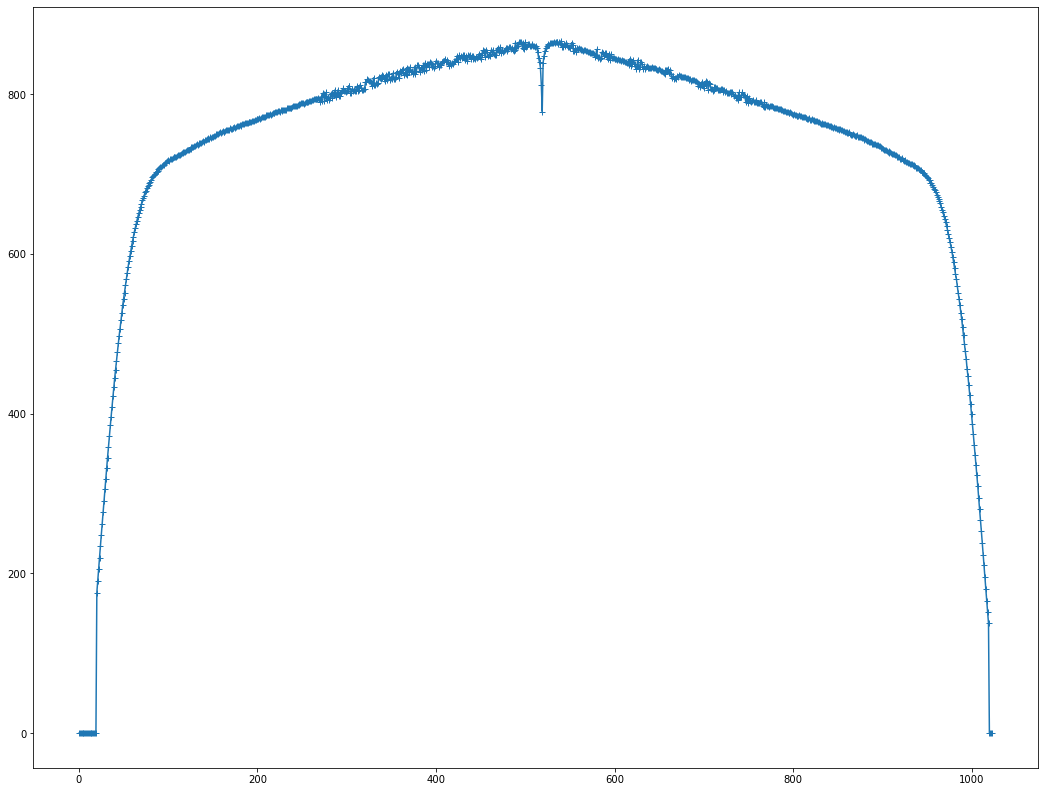

540

In [21]:
accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
Iacc_f = accum_IQ_dat[0::2]/2**10#.astype("float")
Qacc_f = accum_IQ_dat[1::2]/2**10#.astype("float")
Ia, Qa = np.array(Iacc_f).astype(float), np.array(Qacc_f).astype(float)
IQMAG=np.sqrt(Ia**2+Qa**2)

plt.figure(figsize=(8,5))
plt.plot(Ia,label='I')
plt.plot(Qa,label='Q')
plt.legend()
plt.title("ACCUM")
plt.show()

plt.figure(figsize=(18,14))

plt.plot(IQMAG[0:1024][:],"-+")

plt.show()
np.argmax(IQMAG)

<h3>Debug: This code block is used to identify the optimal DDS shift value.</h3>

In [ ]:
peaks = []
for step in range(512):
    dds_shift.write(0x00,step) # WRITING TO DDS SHIFT 
    sleep(.1)
    accum_IQ_dat = get_accum_data(accum_snap).astype("int32")
    I = accum_IQ_dat[0::2]/2**10
    Q = accum_IQ_dat[1::2]/2**10
    IQddc=np.abs(I[0:4096].astype("float")+1j*Q[0:4096].astype("float"))
    peak=IQddc[np.argmax(IQddc[:1024])]
    peaks.append(peak)
    print(step, peak)
peaks = np.array(peaks)
maxpeak = np.max(peaks)
loc = np.argmax(peaks)
print(maxpeak, peaks[loc], loc)